In [187]:
import pandas as pd
import numpy as np
import tensorflow as tf 
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scikeras.wrappers import KerasRegressor
import shutil
import os
import zipfile

##### Model to include best params & sentiment scores

In [188]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism() 


#Code for Hyperparameter Tuning
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df['Datetime'] = df['Date']
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.sort_values(['Coin', 'Datetime'], inplace=True)
  
    df['Return'] = df.groupby('Coin')['Close'].pct_change().shift(-1)  # Next period return as target
    non_features = ['Datetime', 'Coin', 'Date', 'Return']
    feature_cols = [x for x in list(df.columns) if x not in non_features]
    df = df[feature_cols + non_features].dropna()
    df.dropna(inplace=True)
    
    return df, feature_cols

# Prepare sequences for LSTM training
def prepare_sequences(df, feature_cols, sequence_length=20):
    #feature_scaler = RobustScaler()
    #return_scaler = RobustScaler()
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    return_scaler = MinMaxScaler(feature_range=(0, 1))
    
    X_scaled = feature_scaler.fit_transform(df[feature_cols])
    y_scaled = return_scaler.fit_transform(df[['Return']])
    
    X_sequences, y_sequences, dates, close_prices = [], [], df['Datetime'].values[sequence_length:], df['Close'].values[sequence_length:]
    
    for i in range(len(X_scaled) - sequence_length):
        X_sequences.append(X_scaled[i:i+sequence_length])
        y_sequences.append(y_scaled[i+sequence_length])
    
    return np.array(X_sequences), np.array(y_sequences), dates, close_prices, return_scaler

# Split data into training and testing sets
def split_data(X, y, dates, close_prices, train_ratio=0.8):
    split_index = int(len(X) * train_ratio)
    return X[:split_index], X[split_index:], y[:split_index], y[split_index:], dates[split_index:], close_prices[split_index:]



# Function to create model for GridSearchCV
def create_lstm_model(input_shape, layers=1, units_1=50, units_2=50, dropout_rate=0.2, learning_rate=0.001, optimizer='adam'):
    model = Sequential()  # Add this line to initialize the model
    # Explicitly define the input layer
    model.add(Input(shape=input_shape))  # Fix: Define input layer separately
    # First LSTM layer
    if layers == 1:
        
        model.add(LSTM(units=units_1))
    else:
        model.add(LSTM(units=units_1, return_sequences=True))
        model.add(Dropout(dropout_rate))
        
        # Additional LSTM layers
        for i in range(layers-2):
            model.add(LSTM(units=units_2, return_sequences=True))
            model.add(Dropout(dropout_rate))
        
        # Final LSTM layer
        model.add(LSTM(units=units_2))

    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))  # Output layer
    # Convert optimizer string to actual optimizer instance
    optimizer_instance = {
        'adam': tf.keras.optimizers.Adam(learning_rate=learning_rate),
        'rmsprop': tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
        'sgd': tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    }[optimizer]
    model.compile(optimizer=optimizer_instance,
                    loss='mse',
                    metrics=['mae'])
    return model
# Function to train and evaluate the model
def train_and_evaluate_model(df, feature_cols, coin):
    df_coin = df[df['Coin'] == coin]
    X, y, dates, close_prices, return_scaler = prepare_sequences(df_coin, feature_cols)

    # Train-test split (first 80% train, last 20% test)
    X_train, X_test, y_train, y_test, dates_test, close_prices_test = split_data(X, y, dates, close_prices)
    
    # Hyperparameter tuning
    input_shape = (X_train.shape[1], X_train.shape[2])
    # Learning rate adjustment and early stopping
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]
    if coin == 'BTC':
        model = create_lstm_model(input_shape, layers=1, units_1=100, units_2=50, dropout_rate=0.2, learning_rate=0.001, optimizer='adam')
        model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)
    
    elif coin == 'ETH':
        model = create_lstm_model(input_shape, layers=1, units_1=50, units_2=50, dropout_rate=0.2, learning_rate=0.001, optimizer='adam')
        model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=callbacks)
    elif coin == 'SOL':
        model = create_lstm_model(input_shape, layers=1, units_1=100, units_2=50, dropout_rate=0.4, learning_rate=0.001, optimizer='adam')
        model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=callbacks)
    elif coin == 'XRP':
        model = create_lstm_model(input_shape, layers=1, units_1=100, units_2=50, dropout_rate=0.5, learning_rate=0.001, optimizer='adam')
        model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)
    
    # Predict and rescale returns
    y_pred_scaled = model.predict(X_test)
    y_pred = return_scaler.inverse_transform(y_pred_scaled)
    y_test = return_scaler.inverse_transform(y_test.reshape(-1, 1))
    
    return model, y_test, y_pred, dates_test, close_prices_test 



In [189]:
# Function to log trades and calculate cumulative return
def log_trades(dates, actual_returns, predicted_returns, close_prices, coin):
    positions = ['LONG' if pred > 0 else 'SHORT' for pred in predicted_returns.flatten()]
    '''
    fee = 1e-3  # Trading fee (0.1% on Binance)
    strategy_returns = np.zeros_like(actual_returns.flatten())

    prev_position = None
    for i in range(len(actual_returns)):
        curr_position = positions[i]

        # Determine base return based on position
        if curr_position == 'LONG':
            ret = actual_returns[i]
        elif curr_position == 'SHORT':
            ret = -actual_returns[i]
        else:
            ret = 0

        # Apply fee only if position changed
        if prev_position is not None and curr_position != prev_position:
            ret -= fee

        strategy_returns[i] = ret
        prev_position = curr_position
    
    # Compute cumulative return
    cumulative_return = np.cumprod(1 + strategy_returns) - 1'
    '''
    cumulative_return = np.cumprod(1 + (actual_returns * (np.array(positions) == 'LONG') - actual_returns * (np.array(positions) == 'SHORT'))) - 1
    trades = pd.DataFrame({
        'Date': dates,
        'Stock_Close_Price': close_prices,
        'Predicted_Return': predicted_returns.flatten(),
        'Actual_Return': actual_returns,
        'Position': positions,
        'Cumulative_Return': cumulative_return,
        'Coin': coin
    })
    
    return trades 

# Function to plot cumulative returns for each stock
def plot_cumulative_returns(all_trades_df):
    plt.figure(figsize=(12, 6))
    for coin in all_trades_df['Coin'].unique():
        df_coin = all_trades_df[all_trades_df['Coin'] == coin]
        plt.plot(df_coin['Date'], df_coin['Cumulative_Return'], label=coin)
    
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('Cumulative Returns for Each Cryptocurrency')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

In [190]:
# Load dataset
file_path = "./data_with_indicators/crypto_prices_1m_with_indicators.csv"
df, feature_cols = load_and_preprocess_data(file_path)

all_trades = []
unique_coins = ['BTC', 'ETH', 'SOL', 'XRP']


In [ ]:
coin = 'BTC'
print(f"Processing {coin}...")
b_model, b_y_test, b_y_pred, b_dates_test, b_close_prices_test = train_and_evaluate_model(df, feature_cols, coin)


Processing BTC...
Epoch 1/50


2025-03-28 10:45:06.728577: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-28 10:45:06.729004: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

2122/2123 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071 - mae: 0.0496

2025-03-28 10:45:19.837122: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-28 10:45:19.837506: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

2123/2123 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0071 - mae: 0.0496 - val_loss: 4.7986e-04 - val_mae: 0.0139 - learning_rate: 0.0010
Epoch 2/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 7.5623e-04 - mae: 0.0202 - val_loss: 5.6822e-04 - val_mae: 0.0165 - learning_rate: 0.0010
Epoch 3/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 5.3494e-04 - mae: 0.0160 - val_loss: 4.7106e-04 - val_mae: 0.0136 - learning_rate: 0.0010
Epoch 4/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 4.6078e-04 - mae: 0.0141 - val_loss: 4.6868e-04 - val_mae: 0.0136 - learning_rate: 0.0010
Epoch 5/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 4.3193e-04 - mae: 0.0132 - val_loss: 4.6823e-04 - val_mae: 0.0137 - learning_rate: 5.0000e-04
Epoch 6/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 4.3091e-04 - mae: 0.0132 - val_loss: 4.6846e-04 - val_mae: 0.0137 - learning_rate: 5.0000e-04
Epoch 7/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 4.2879e-04 - mae: 0.0131 -

In [181]:
btc_trades = log_trades(b_dates_test, b_y_test.flatten(), b_y_pred.flatten(), b_close_prices_test, coin)
all_trades.append(btc_trades)

In [161]:
coin = 'ETH'
print(f"Processing {coin}...")
e_model, e_y_test, e_y_pred, e_dates_test, e_close_prices_test = train_and_evaluate_model(df, feature_cols, coin)


Processing ETH...
Epoch 1/50
1055/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0176 - mae: 0.0835

2025-03-28 10:32:09.463182: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-28 10:32:09.463537: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1062/1062 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0175 - mae: 0.0832 - val_loss: 2.0417e-04 - val_mae: 0.0114 - learning_rate: 0.0010
Epoch 2/50
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0017 - mae: 0.0332 - val_loss: 1.0151e-04 - val_mae: 0.0071 - learning_rate: 0.0010
Epoch 3/50
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 9.4792e-04 - mae: 0.0244 - val_loss: 1.0376e-04 - val_mae: 0.0074 - learning_rate: 0.0010
Epoch 4/50
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.1375e-04 - mae: 0.0158 - val_loss: 7.4143e-05 - val_mae: 0.0057 - learning_rate: 0.0010
Epoch 5/50
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.5542e-04 - mae: 0.0091 - val_loss: 7.3050e-05 - val_mae: 0.0057 - learning_rate: 0.0010
Epoch 6/50
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 8.7318e-05 - mae: 0.0061 - val_loss: 7.0927e-05 - val_mae: 0.0055 - learning_rate: 5.0000e-04
Epoch 7/50
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 7.7399e-05 - mae: 0.0055 - val_loss: 7.26

2025-03-28 10:33:02.048971: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-03-28 10:33:02.049347: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [182]:
# Log trades and update cumulative returns
eth_trades = log_trades(e_dates_test, e_y_test.flatten(), e_y_pred.flatten(), e_close_prices_test, coin)
all_trades.append(eth_trades)

In [ ]:
coin = 'SOL'
print(f"Processing {coin}...")
s_model, s_y_test, s_y_pred, s_dates_test, s_close_prices_test = train_and_evaluate_model(df, feature_cols, coin)


Processing SOL...
Epoch 1/50
4245/4246 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0109 - mae: 0.0613

2025-03-28 10:33:23.053953: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-28 10:33:23.054299: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

4246/4246 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0109 - mae: 0.0613 - val_loss: 0.0013 - val_mae: 0.0252 - learning_rate: 0.0010
Epoch 2/50
4246/4246 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0013 - mae: 0.0245 - val_loss: 0.0013 - val_mae: 0.0249 - learning_rate: 0.0010
Epoch 3/50
4246/4246 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0012 - mae: 0.0225 - val_loss: 0.0013 - val_mae: 0.0249 - learning_rate: 0.0010
Epoch 4/50
4246/4246 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0012 - mae: 0.0223 - val_loss: 0.0013 - val_mae: 0.0249 - learning_rate: 0.0010
Epoch 5/50
4246/4246 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0012 - mae: 0.0222 - val_loss: 0.0013 - val_mae: 0.0249 - learning_rate: 5.0000e-04
Epoch 6/50
4246/4246 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0012 - mae: 0.0222 - val_loss: 0.0013 - val_mae: 0.0249 - learning_rate: 5.0000e-04
Epoch 7/50
4246/4246 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 0.0012 - mae: 0.0222 - val_loss: 0.0013 - val_mae: 0.0249 - learning_r

2025-03-28 10:37:33.496515: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-03-28 10:37:33.496866: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [183]:
# Log trades and update cumulative returns
sol_trades = log_trades(s_dates_test, s_y_test.flatten(), s_y_pred.flatten(), s_close_prices_test, coin)
all_trades.append(sol_trades)

In [165]:
coin = 'XRP'
print(f"Processing {coin}...")
xrp_model, xrp_y_test, xrp_y_pred, xrp_dates_test, xrp_close_prices_test = train_and_evaluate_model(df, feature_cols, coin)


Processing XRP...
Epoch 1/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0137 - mae: 0.0680

2025-03-28 10:37:48.943600: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-28 10:37:48.943972: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

2123/2123 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.0137 - mae: 0.0680 - val_loss: 1.5284e-04 - val_mae: 0.0090 - learning_rate: 0.0010
Epoch 2/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 4.9640e-04 - mae: 0.0168 - val_loss: 1.3099e-04 - val_mae: 0.0079 - learning_rate: 0.0010
Epoch 3/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 1.7884e-04 - mae: 0.0089 - val_loss: 1.4297e-04 - val_mae: 0.0085 - learning_rate: 0.0010
Epoch 4/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 1.6863e-04 - mae: 0.0085 - val_loss: 1.2524e-04 - val_mae: 0.0076 - learning_rate: 0.0010
Epoch 5/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 1.6019e-04 - mae: 0.0081 - val_loss: 1.2464e-04 - val_mae: 0.0076 - learning_rate: 5.0000e-04
Epoch 6/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 1.5957e-04 - mae: 0.0081 - val_loss: 1.2510e-04 - val_mae: 0.0076 - learning_rate: 5.0000e-04
Epoch 7/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 1.5783e-04 - mae: 0.0080 -

2025-03-28 10:39:54.415485: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-03-28 10:39:54.415835: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [184]:
# Log trades and update cumulative returns
xrp_trades = log_trades(xrp_dates_test, xrp_y_test.flatten(), xrp_y_pred.flatten(), xrp_close_prices_test, coin)
all_trades.append(xrp_trades)

In [185]:
all_trades = [btc_trades, eth_trades, sol_trades, xrp_trades]

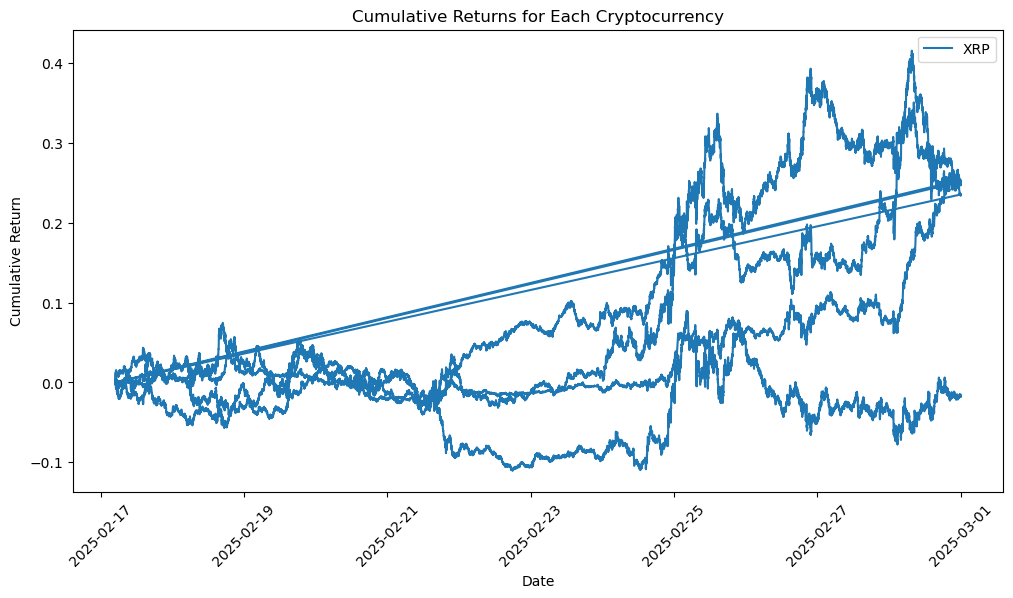

In [186]:

# Combine all trades into a single DataFrame
all_trades_df = pd.concat(all_trades, ignore_index=True)

# Plot cumulative returns for all stocks
plot_cumulative_returns(all_trades_df)

In [169]:
all_trades_df['Rolling_Risk'] = all_trades_df.groupby('Coin')['Actual_Return'].transform(lambda x: x.rolling(window=10).std())
all_trades_df['Rolling_Average'] = all_trades_df.groupby('Coin')['Actual_Return'].transform(lambda x: x.rolling(window=10).mean())


In [170]:
all_trades_df.to_csv("returns.csv")

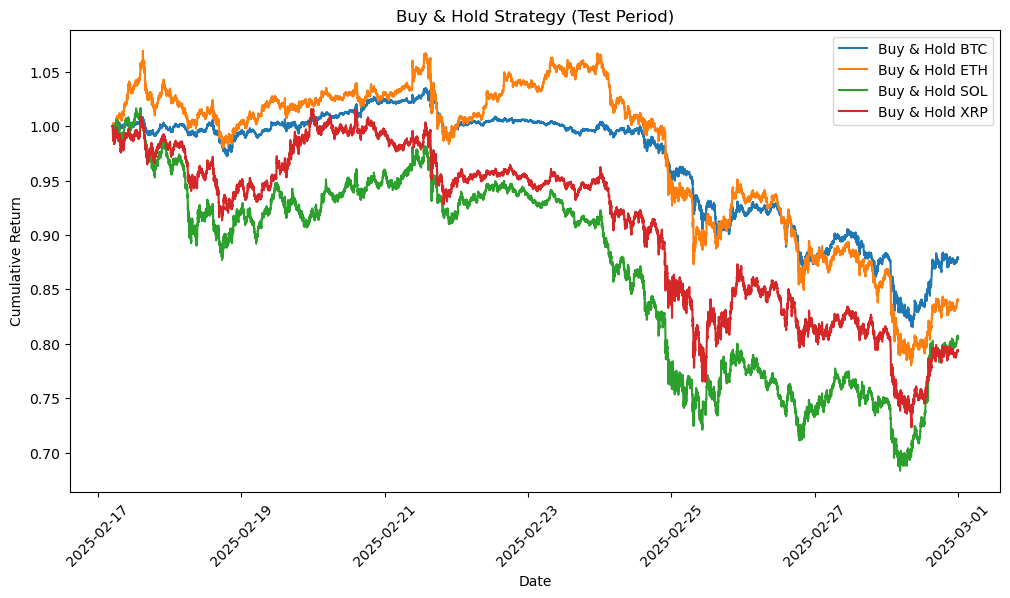

In [ ]:
# Reload the dataset
file_path = "./data_with_indicators/crypto_prices_1m_with_indicators.csv"
df, feature_cols = load_and_preprocess_data(file_path)

# Function to plot Buy & Hold strategy for the test period (last 20% of the dataset)
def plot_buy_and_hold_test_period(df):
    plt.figure(figsize=(12, 6))

    for coin in df['Coin'].unique():
        df_coin = df[df['Coin'] == coin].sort_values('Datetime')

        # Split data (80% train, 20% test)
        split_index = int(len(df_coin) * 0.8)
        df_test = df_coin.iloc[split_index:]  # Select last 20%

        if df_test.empty:
            continue  # Skip if no test data

        initial_price = df_test['Close'].iloc[0]
        buy_and_hold_returns = df_test['Close'] / initial_price  # Normalize returns

        plt.plot(df_test['Datetime'], buy_and_hold_returns, label=f'Buy & Hold {coin}')

    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('Buy & Hold Strategy (Test Period)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

# Plot the Buy & Hold strategy for the test period
plot_buy_and_hold_test_period(df) 

In [ ]:
# Function to calculate returns for both strategies during the test period
def calculate_strategy_returns(df, all_trades_df):
    results = []

    for coin in df['Coin'].unique():
        df_coin = df[df['Coin'] == coin].sort_values('Datetime')

        # Split data (80% train, 20% test)
        split_index = int(len(df_coin) * 0.8)
        df_test = df_coin.iloc[split_index:]  # Select last 20%

        if df_test.empty:
            continue  # Skip if no test data

        # Buy & Hold Strategy Return
        initial_price = df_test['Close'].iloc[0]
        final_price = df_test['Close'].iloc[-1]
        buy_and_hold_return = (final_price / initial_price) - 1

        # Trading Strategy Return (from the logged trades)
        df_trades = all_trades_df[all_trades_df['Coin'] == coin]
        strategy_return = df_trades['Cumulative_Return'].iloc[-1] if not df_trades.empty else None

        results.append({
            "Coin": coin,
            "Buy & Hold Return (%)": round(buy_and_hold_return * 100, 2),
            "Trading Strategy Return (%)": round(strategy_return * 100, 2) if strategy_return is not None else None
        })

    return pd.DataFrame(results)

# Check if trading results exist
if 'all_trades_df' in globals():
    strategy_returns_df = calculate_strategy_returns(df, all_trades_df)
    print(strategy_returns_df)
else:
    print("Trading strategy results are missing. Please re-run the trading model first.")




  Coin  Buy & Hold Return (%)  Trading Strategy Return (%)
0  BTC                 -12.23                       -54.83
1  ETH                 -15.96                       -94.48
2  SOL                 -19.38                       -71.65
3  XRP                 -20.68                       -90.72
